In [1]:
import pandas as pd
import networkx as nx
import osmnx as ox
import config
import random
import math
import util
import testing.helpers.testing_helper as test_helper


In [2]:
G = ox.load_graphml(filepath=f"{config.testing_graphml_path}/merged_routes.graphml")

# bool_replace = {"True": True, "False": False}
# nodes["community_route"] = nodes["community_route"].map(bool_replace).fillna(False)
# # merged_nodes["community_route"] = merged_nodes["community_route"].fillna(False)
# nodes["actual_stop"] = nodes["actual_stop"].map(bool_replace).fillna(False)

In [3]:
%%time
# get sets of generated and real bus stops
nodes, edges = ox.graph_to_gdfs(G)
nodes = nodes.replace({"True": True, "False": False})
actual_stops = nodes[nodes["actual_stop"] == True]
generated_stops = nodes[nodes["community_route"] == True]

CPU times: user 1.31 s, sys: 51.7 ms, total: 1.36 s
Wall time: 1.39 s


In [4]:
# determine sample size to use
population_data = pd.read_csv(f"{config.population_data_path}/donegal_townlands_all_coordinates.csv")
total_population = sum(population_data["population"])

# Cochran’s Formula
sample_size = test_helper.sample_size(int(total_population),
                                      margin_error=.05,
                                      confidence_level=.95)
sample_size

383.23017177926187

In [5]:
# round sample size up to 384
sample_size = math.ceil(sample_size)

# select pseudorandom sample nodes
random.seed(303)
%time sample_nodes = random.sample(list(G.nodes()), sample_size)

CPU times: user 789 µs, sys: 40 µs, total: 829 µs
Wall time: 1.08 ms


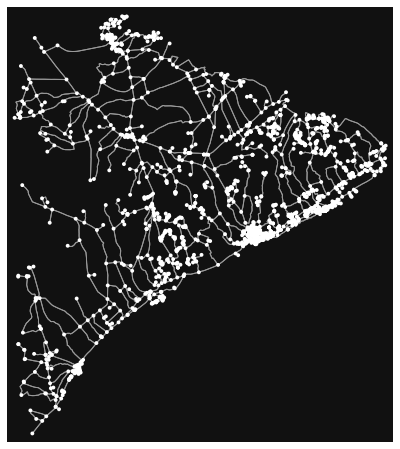

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3279cd1fa0>)

In [6]:
# 20km radius
test = nx.generators.ego_graph(G, sample_nodes[300], radius=20000, distance="length")
ox.plot_graph(test)

In [12]:
nodes, edges = ox.graph_to_gdfs(test)
nodes = nodes.replace({"True": True, "False": False})

actual_stops_present = list(set(actual_stops["osmid"]).intersection(nodes["osmid"]))
gen_stops_present = list(set(generated_stops["osmid"]).intersection(nodes["osmid"]))

In [17]:
%%time
actual_stops_simple_paths = []
for stop in actual_stops_present:
    paths = list(nx.all_shortest_paths(test, sample_nodes[300], stop,  weight="length"))
    actual_stops_simple_paths.append(paths)

gen_stops_simple_paths = []
for stop in gen_stops_present:
    paths = list(nx.all_shortest_paths(test, sample_nodes[300], stop,  weight="length"))
    gen_stops_simple_paths.append(paths)

CPU times: user 614 ms, sys: 0 ns, total: 614 ms
Wall time: 626 ms


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

sample_node = nodes[nodes["osmid"] == sample_nodes[300]]
gen_stops = nodes[nodes["community_route"] == True]
ll_stops = nodes[nodes["actual_stop"] == True]
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_facecolor("black")

plt.rc("legend", fontsize=25,
       facecolor="black")

edges.plot(
    ax=ax,
    edgecolor="grey",
    linewidth=1,
    facecolor="none",
    zorder=1,
    alpha=0.8
)

gen_stops.plot(
    ax=ax,
    marker="o",
    markersize=100,
    #column="community",
    #cmap="hsv",
    zorder=2,
    #legend=legend,
    categorical=True
)

ll_stops.plot(
    ax=ax,
    marker="o",
    markersize=100,
    #column="community",
    #cmap="hsv",
    zorder=2,
    #legend=legend,
    categorical=True
)

sample_node.plot(
    ax=ax,
    marker=7,
    markersize=200,
    #column="community",
    #cmap="hsv",
    zorder=2,
    #legend=legend,
    categorical=True
)

In [ ]:
##################
# analysis  - mean distance to a bus stop in either system
#           -